# 1. IBD graph 

In [1]:
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import bernoulli

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
EPS = 1e-10
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [4]:
def generate_matrices(population_sizes, p, teta=5, offset = 3.0):
    pop_index = []
    n_pops = len(population_sizes)
    for i in range(n_pops):
        pop_index += [i]*population_sizes[i]

    pop_index = np.array(pop_index)
    print(f"{n_pops=}")
    blocks_sums = [[np.zeros(shape=(population_sizes[i], population_sizes[j])) for i in range(n_pops)] for j in range(n_pops)]
    blocks_counts = [[np.zeros(shape=(population_sizes[i], population_sizes[j])) for i in range(n_pops)] for j in range(n_pops)]

    for pop_i in range(n_pops):
        for pop_j in range(pop_i+1):
            print(f"{pop_i=} {pop_j=}")
            pop_cross = population_sizes[pop_i] * population_sizes[pop_j]
            bern_samples = bernoulli.rvs(p[pop_i,pop_j], size = pop_cross)
            total_segments = np.sum(bern_samples)
            print(f"{total_segments=}")
            exponential_samples = np.random.exponential(teta, size=total_segments) + offset
            position = 0
            exponential_totals_samples = np.zeros(pop_cross, dtype=np.float64)
            mean_totals_samples = np.zeros(pop_cross, dtype=np.float64)
            exponential_totals_samples[bern_samples==1] = exponential_samples

            bern_samples = np.reshape(bern_samples, newshape=(population_sizes[pop_i], population_sizes[pop_j]))
            exponential_totals_samples=np.reshape(exponential_totals_samples, newshape=(population_sizes[pop_i], population_sizes[pop_j]))
            if(pop_i==pop_j):
                bern_samples = np.tril(bern_samples,-1)
                exponential_totals_samples = np.tril(exponential_totals_samples,-1)
            blocks_counts[pop_i][pop_j] = bern_samples
            blocks_sums[pop_i][pop_j] = exponential_totals_samples
    return np.nan_to_num(symmetrize(np.block(blocks_counts))), np.nan_to_num(symmetrize(np.block(blocks_sums))), pop_index


def generate_graph(means, counts, pop_index):
    indiv = list(range(counts.shape[0]))
    #print(indiv)
    G = nx.Graph()
    structr = [ (indiv[i],{"means": np.concatenate((means[i],counts[i])), "y": pop_index[i]}) for i in range(len(pop_index))]
    #print(structr)
    G.add_nodes_from(structr)
    for i in range(counts.shape[0]):
        for j in range(i):
            if(means[i][j]):
                G.add_edge(i, j, len = 1/(counts[i][j] + EPS), weight = counts[i][j])

    # remove isolated nodes
    #G.remove_nodes_from(list(nx.isolates(G)))
    return G

In [5]:
### code for modelling
#N = 75
N = 1000
population_sizes = [N,N,N, N, N]
#p = np.array([[0.5,0.45,0.45],[0.45,0.5,0.45], [0.45,0.45,0.5]])
p = np.array([[0.11097308, 0.0012959 , 0.00127431, 0.00258547, 0.00579579],
       [0.0012959 , 0.01644648, 0.00550097, 0.00708765, 0.00633572],
       [0.00127431, 0.00550097, 0.01359845, 0.00528573, 0.00422982],
       [0.00258547, 0.00708765, 0.00528573, 0.01403417, 0.00744347],
       [0.00579579, 0.00633572, 0.00422982, 0.00744347, 0.01977209]])

means, counts, pop_index = generate_matrices(population_sizes, p)
G = generate_graph(means, counts, pop_index)
print(G)
#print(G.edges)

n_pops=5
pop_i=0 pop_j=0
total_segments=111041
pop_i=1 pop_j=0
total_segments=1261
pop_i=1 pop_j=1
total_segments=16412
pop_i=2 pop_j=0
total_segments=1294
pop_i=2 pop_j=1
total_segments=5472
pop_i=2 pop_j=2
total_segments=13628
pop_i=3 pop_j=0
total_segments=2620
pop_i=3 pop_j=1
total_segments=7084
pop_i=3 pop_j=2
total_segments=5276
pop_i=3 pop_j=3
total_segments=14028
pop_i=4 pop_j=0
total_segments=5782
pop_i=4 pop_j=1
total_segments=6388
pop_i=4 pop_j=2
total_segments=4247
pop_i=4 pop_j=3
total_segments=7539
pop_i=4 pop_j=4
total_segments=19705
Graph with 5000 nodes and 134107 edges


# 2. Compute features of the generated nodes

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import sys
sys.path.append("../utils")
import ibdloader
import baseheuristic as bh

datapath = "../datasets/"

#pairs_1, weights, labels, labeldict
labels = np.array(pop_index)
labeldict = {"pop"+str(idx):idx for idx in range(len(population_sizes))}
print (labels)
print(labeldict)

[0 0 0 ... 4 4 4]
{'pop0': 0, 'pop1': 1, 'pop2': 2, 'pop3': 3, 'pop4': 4}


In [7]:
pairs = []
weights = []
for ed in G.edges:
    a, b = ed
    d = G.get_edge_data(a,b)
    pairs.append([a,b,1])
    weights.append([d['weight']])
    

pairs = np.array(pairs)
weights = np.array(weights)
print(weights)

#prepare full graph
G = nx.Graph()
for idx, edge in enumerate(pairs):
    G.add_edge(edge[0], edge[1], weight=weights[idx])

print(G)
#group nodes

nodeclasses = {}
for label in labeldict:
    idx = labeldict[label]
    nodeclasses[label] = np.argwhere(labels==idx).flatten()


    
print("Class size")
for label in nodeclasses:
    print (f"{label}: {nodeclasses[label].shape[0]}")

print(len(G.nodes))

[[ 3.41072408]
 [ 9.65608509]
 [ 7.69765405]
 ...
 [ 9.66054432]
 [ 5.20168936]
 [12.05460829]]
Graph with 5000 nodes and 134107 edges
Class size
pop0: 1000
pop1: 1000
pop2: 1000
pop3: 1000
pop4: 1000
5000


Distribution of ibd sum
Total values: 134107 min: [3.00015228] max: [66.45059152] ave: 7.992898822313508
filtered values: 134097 min: 3.000152279260957 max: 49.073731525507675 ave: 7.989409365905383


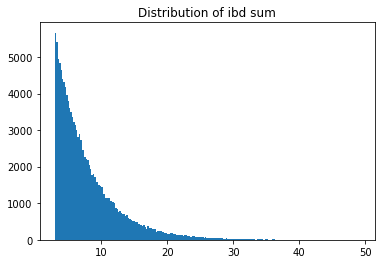

Distribution of ibd count
Total values: 134107 min: 1 max: 1 ave: 1.0
filtered values: 134107 min: 1 max: 1 ave: 1.0


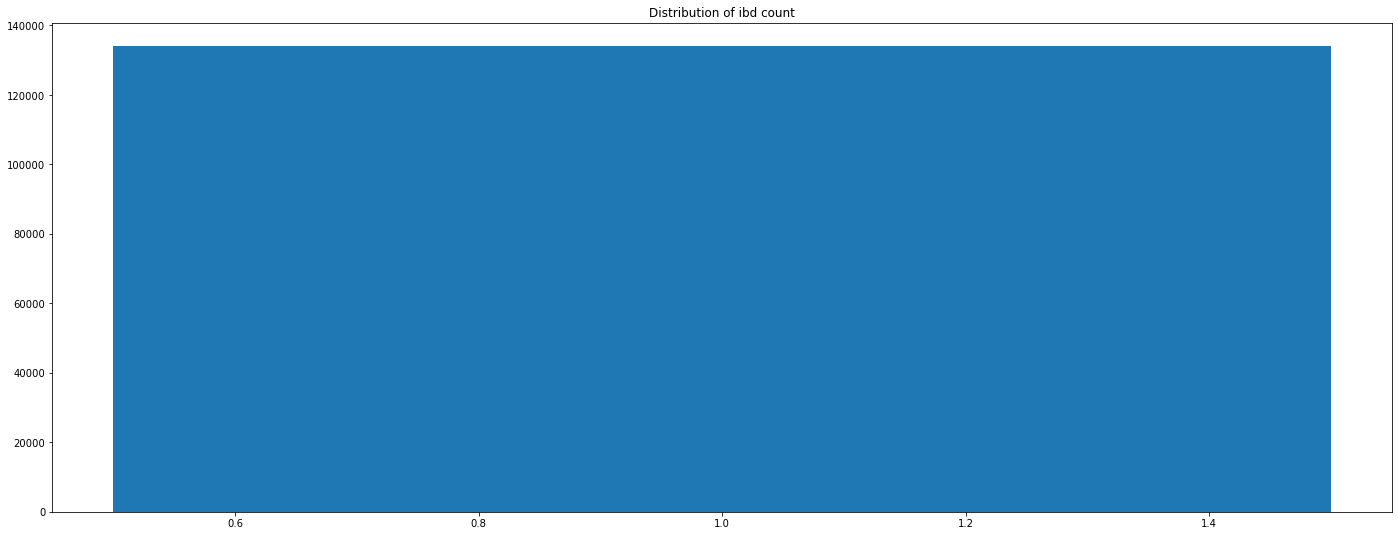

In [8]:
bh.plot_distribution(weights, 50, "Distribution of ibd sum")
bh.plot_distribution(pairs[:,2], 100, "Distribution of ibd count")

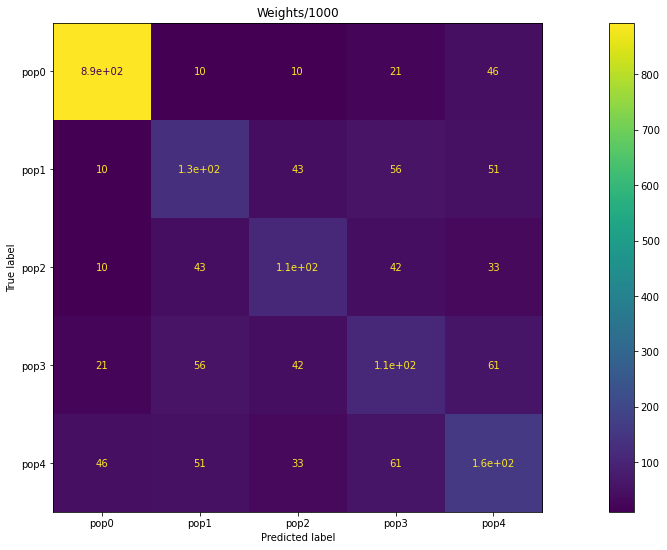

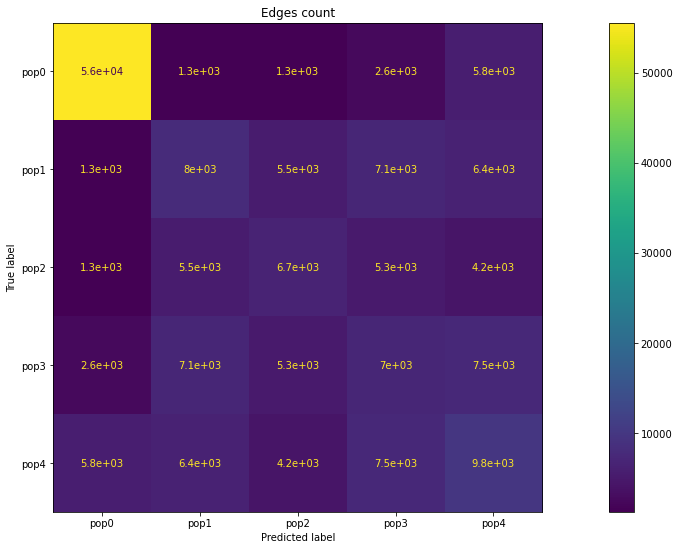

In [9]:
weimatrix, countmatrix, distr = bh.getweightandcountmatrices(G, nodeclasses, labeldict, plot_distr=False)
# в тысячах
cm_display = ConfusionMatrixDisplay(weimatrix/1000, display_labels=labeldict.keys()).plot()
cm_display.ax_.set_title("Weights/1000")
plt.show()
cm_display = ConfusionMatrixDisplay(countmatrix, display_labels=labeldict.keys()).plot()
cm_display.ax_.set_title("Edges count")
plt.show()


# Classification

Compute confusion matrices for the following features:

- sum of shared ibd segment lengths between node and population per edge count (IbdSumPerEdge)
- sum of shared ibd segment lengths between node and population (IbdSum)
- longest shared ibd segment between node and population (LongestIbd)
- number of shared ibd segments between node and population (SegmentCount)
- number of edges from node to population per population size (EdgeCountPerClassSize) 
- number of edges from node to population  (EdgeCount)


features collected in 139.95510411262512 seconds

number of edges from node to population: Accuracy: 0.9552, correct: 4776, total: 5000
              precision    recall  f1-score   support

        pop0       1.00      1.00      1.00      1000
        pop1       0.90      0.97      0.93      1000
        pop2       0.98      0.94      0.96      1000
        pop3       0.96      0.89      0.92      1000
        pop4       0.95      0.98      0.96      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



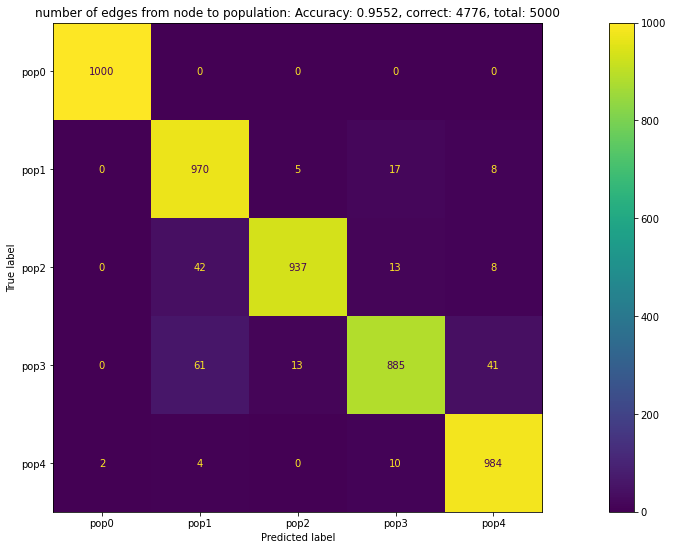

number of edges from node to population per population size: Accuracy: 0.9552, correct: 4776, total: 5000
              precision    recall  f1-score   support

        pop0       1.00      1.00      1.00      1000
        pop1       0.90      0.97      0.93      1000
        pop2       0.98      0.94      0.96      1000
        pop3       0.96      0.89      0.92      1000
        pop4       0.95      0.98      0.96      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



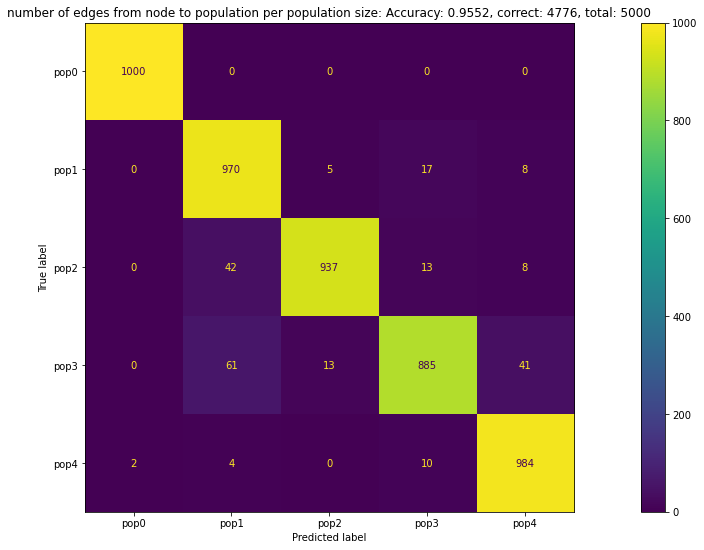

number of shared ibd segments between node and population: Accuracy: 0.9552, correct: 4776, total: 5000
              precision    recall  f1-score   support

        pop0       1.00      1.00      1.00      1000
        pop1       0.90      0.97      0.93      1000
        pop2       0.98      0.94      0.96      1000
        pop3       0.96      0.89      0.92      1000
        pop4       0.95      0.98      0.96      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



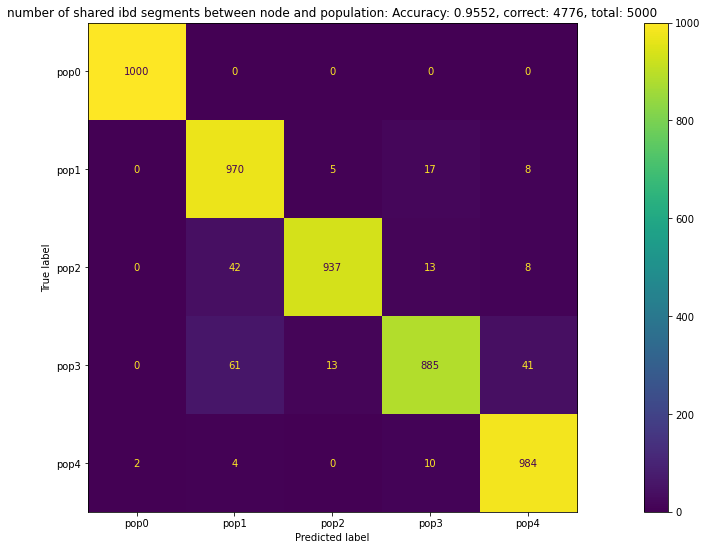

longest shared ibd segment between node and population: Accuracy: 0.5172, correct: 2586, total: 5000
              precision    recall  f1-score   support

        pop0       0.75      0.90      0.82      1000
        pop1       0.45      0.42      0.44      1000
        pop2       0.53      0.47      0.50      1000
        pop3       0.38      0.36      0.37      1000
        pop4       0.42      0.43      0.43      1000

    accuracy                           0.52      5000
   macro avg       0.51      0.52      0.51      5000
weighted avg       0.51      0.52      0.51      5000



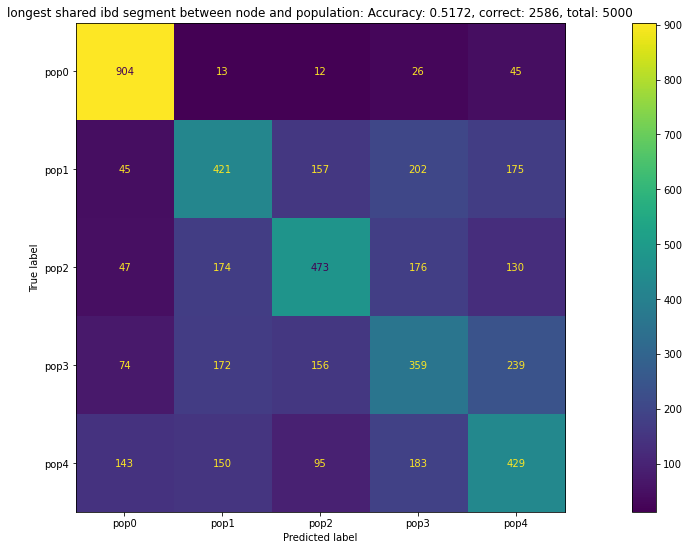

sum of shared ibd segment lengths between node and population: Accuracy: 0.9210, correct: 4605, total: 5000
              precision    recall  f1-score   support

        pop0       0.99      1.00      1.00      1000
        pop1       0.88      0.92      0.90      1000
        pop2       0.96      0.90      0.93      1000
        pop3       0.90      0.83      0.86      1000
        pop4       0.88      0.96      0.92      1000

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



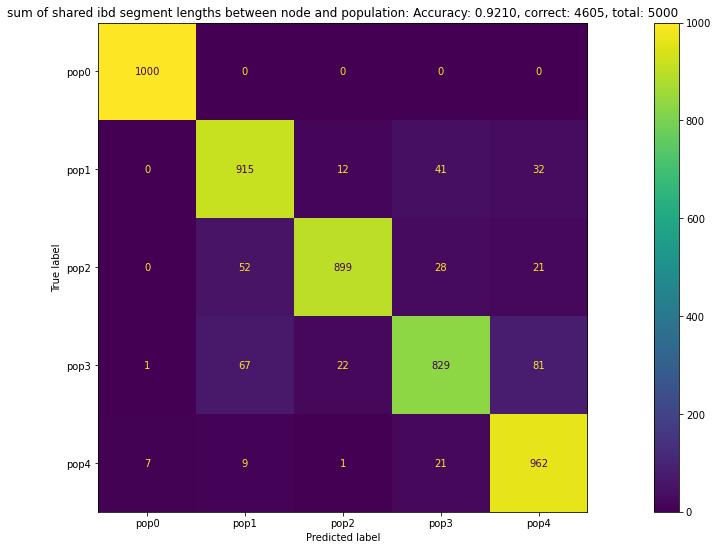

sum of shared ibd segment lengths between node and population per edge count: Accuracy: 0.1600, correct: 800, total: 5000
              precision    recall  f1-score   support

        pop0       0.18      0.18      0.18      1000
        pop1       0.17      0.16      0.16      1000
        pop2       0.17      0.17      0.17      1000
        pop3       0.16      0.15      0.16      1000
        pop4       0.13      0.13      0.13      1000

    accuracy                           0.16      5000
   macro avg       0.16      0.16      0.16      5000
weighted avg       0.16      0.16      0.16      5000



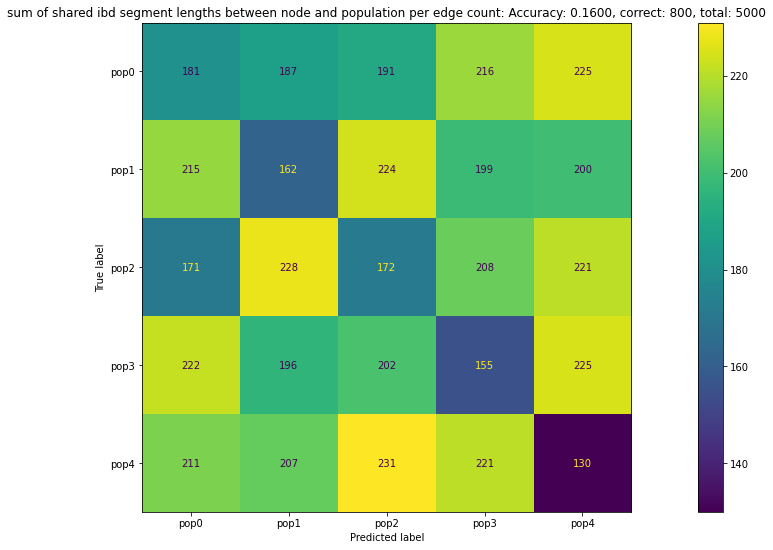

In [10]:
import time
start = time.time()
faketranslation = np.arange(len(G.nodes))
featuredict = bh.getfeatures(G, G.nodes, nodeclasses, labeldict, pairs, faketranslation )
print(f"features collected in {time.time()-start} seconds\n")

simplepredictions = bh.getsimplepred(featuredict)
for feature in featuredict:
    prediction = simplepredictions[feature]
    title = featuredict[feature]["comment"]
    bh.show_prediction(labels, prediction, labeldict.keys(), title)    

In [13]:
for feature in featuredict:
    print(f"{feature}: {featuredict[feature]['comment']}")

SegmentCount: number of edges from node to population
SegmentCountPerClassize: number of edges from node to population per population size
SegmentCountWMult: number of shared ibd segments between node and population
LongestIbd: longest shared ibd segment between node and population
IbdSum: sum of shared ibd segment lengths between node and population
IbdSumPerEdge: sum of shared ibd segment lengths between node and population per edge count


# Classification performance

1. Separate 20% of val nodes, 20% of test nodes, the rest are train nodes
2. For test nodes collect features based on train+val nodes only

In [ ]:
testshare = 0.2
valshare = 0.2
trainnodeclasses, valnodeclasses, testnodeclasses = bh.dividetrainvaltest(nodeclasses, valshare, testshare)

print("train|test distribution")
for c in trainnodeclasses:
    print(c, ":", trainnodeclasses[c].shape[0], ":", valnodeclasses[c].shape[0], ":", testnodeclasses[c].shape[0])

trainnodes, valnodes, testnodes = bh.gettrainvaltestnodes(trainnodeclasses, valnodeclasses, testnodeclasses)
print("train nodes:", trainnodes.shape[0])
print("val nodes:", valnodes.shape[0])
print("test nodes:", testnodes.shape[0])

testlabels = np.array([ labels[node] for node in testnodes])
translation = np.arange(len(labels))

for lbl in labeldict:
    print(trainnodeclasses[lbl][:10])

featuredict = bh.getfeatures(G, testnodes, trainnodeclasses, pairs, labeldict, translation)
predictions = bh.getsimplepred(featuredict)

predictedlabels = np.array([ predictions["SegmentCount"][node] for node in testnodes])

title = featuredict["SegmentCount"]["comment"]
bh.show_prediction(testlabels, predictedlabels, labeldict.keys(), title)